## Импорты библиотек

In [1]:
from time import time, sleep

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm

from sqlalchemy import create_engine, Column, Integer, String, TIMESTAMP, ARRAY
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings('ignore')

import json
pd.set_option("display.max_columns", None)

## Чтение данных

In [2]:
engine = create_engine(f"postgresql+psycopg2://"
                       f"postgres:"
                       f"1234qwerty@"
                       f"localhost/"
                       f"arduino")

In [3]:
data = pd.read_sql_table(table_name='boiler',
                                    con=engine,
                                    schema='public',
                                    index_col='id')

data = data.sort_index()
data.loc[:,"t_home":"t_off"] = data.loc[:,"t_home":"t_off"].astype('float')
data.loc[:,"boiler_status"] = data.loc[:,"boiler_status"].astype('int')

data = data.set_index('time')

In [4]:
# устранение пропусков от потери связи уличных датчиков
while(data.loc[data['t_outdoor'] == -99, 't_outdoor'].shape[0] !=0):
    data.loc[data['t_outdoor'] == -99, 't_outdoor'] = data['t_outdoor'].shift(-1)
    data.loc[data['h_outdoor'] == -99, 'h_outdoor'] = data['h_outdoor'].shift(-1)
    data.loc[data['t_cellar'] == -99, 't_cellar'] = data['t_cellar'].shift(-1)
    data.loc[data['h_cellar'] == -99, 'h_cellar'] = data['h_cellar'].shift(-1)

    # устранение пропусков от потери связи домашних датчиков
while(data.loc[data['t_home'] == -99, 't_home'].shape[0] !=0):
    data.loc[data['t_home'] == -99, 't_home'] = data['t_home'].shift(-1)
    data.loc[data['h_home'] == -99, 'h_home'] = data['h_home'].shift(-1)

## Срез данных

In [5]:
first_time = data.index[0]
last_time = data.index[-1]
data = data[first_time:last_time]

## Графики

### Дом

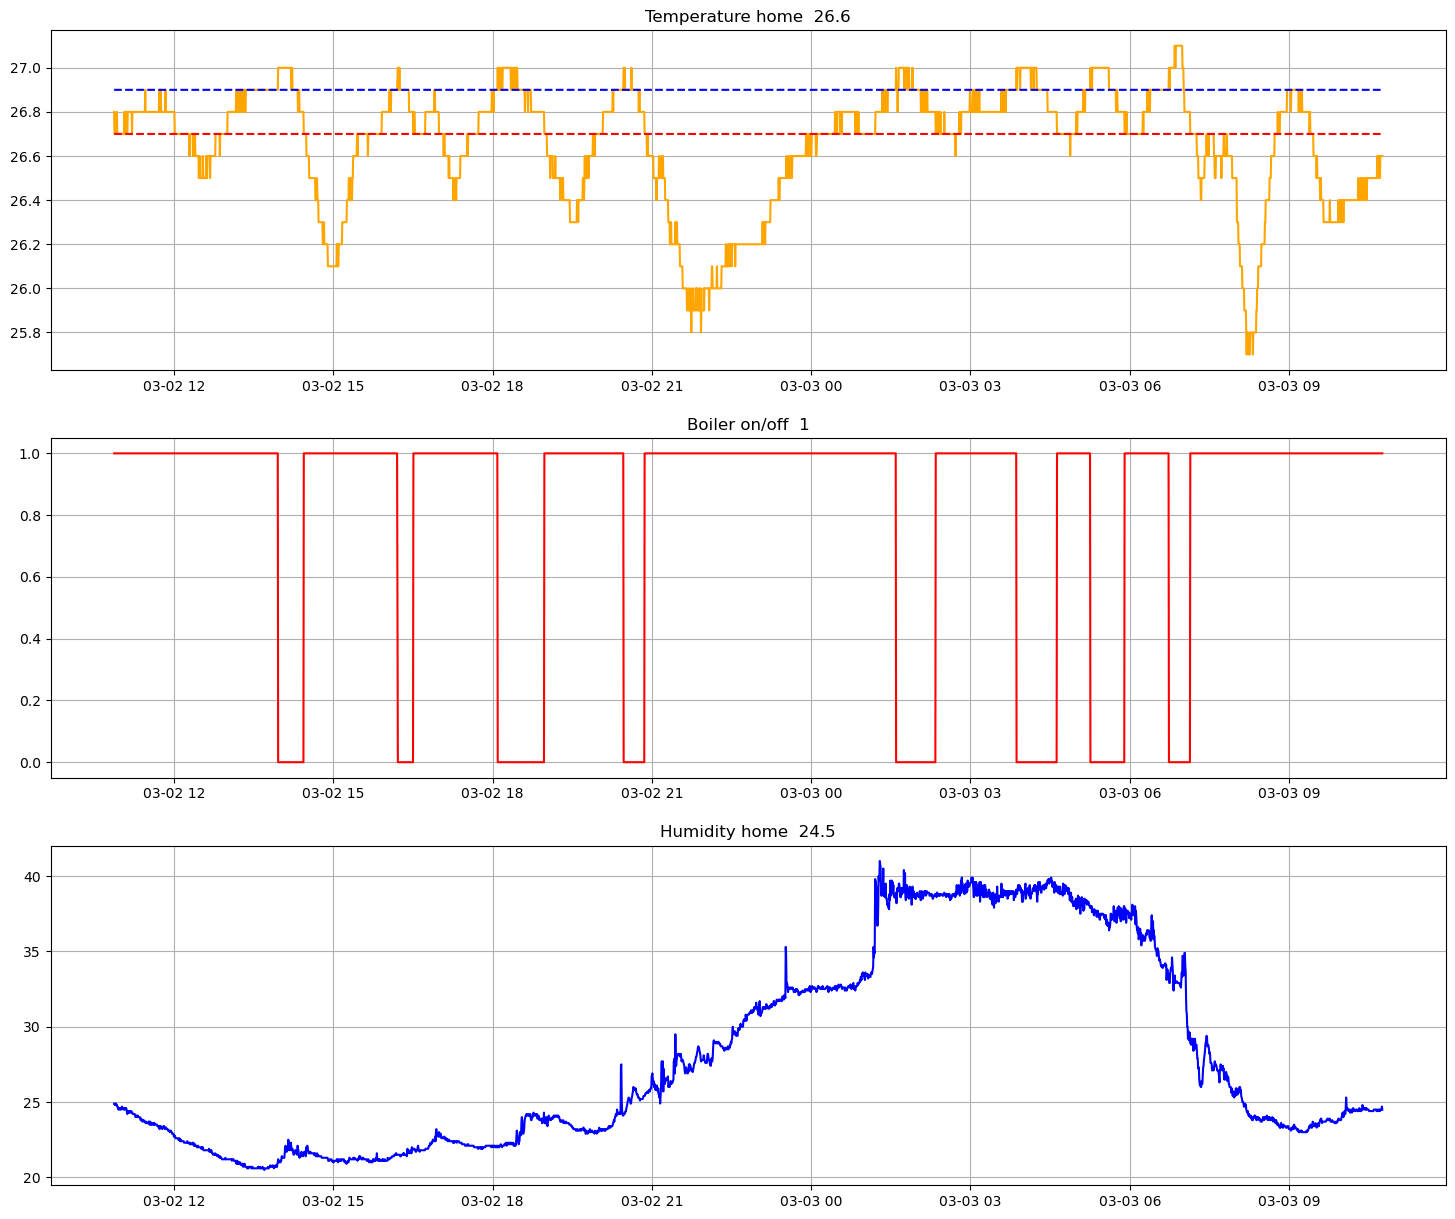

In [6]:
fig, axs = plt.subplots(3, 1,figsize=(18, 15))
axs[0].grid(True)
axs[0].set_title('Temperature home  '+str(data['t_home'][-1]))
axs[0].plot(data.index, data['t_home'], color='orange')
axs[0].plot(data.index, data['t_on'], color='red', ls='--')
axs[0].plot(data.index, data['t_off'], color='blue', ls='--')
axs[1].grid(True)
axs[1].set_title('Boiler on/off  '+str(data['boiler_status'][-1]))
axs[1].plot(data.index, data['boiler_status'], color='red')
axs[2].grid(True)
axs[2].set_title('Humidity home  '+str(data['h_home'][-1]))
axs[2].plot(data.index, data['h_home'], color='blue')
plt.show()

### Атмосферное давление

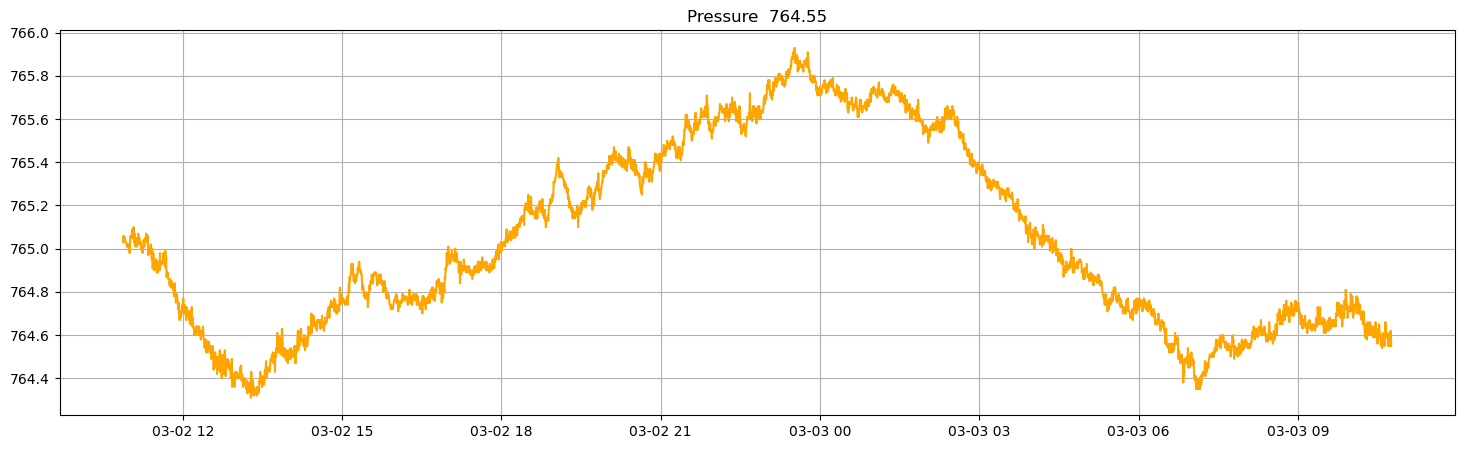

In [7]:
fig, axs = plt.subplots(1, 1,figsize=(18, 5))
axs.grid(True)
axs.set_title('Pressure  '+str(data['pressure'][-1]))
axs.plot(data.index, data['pressure'], color='orange')
plt.show()

### Улица

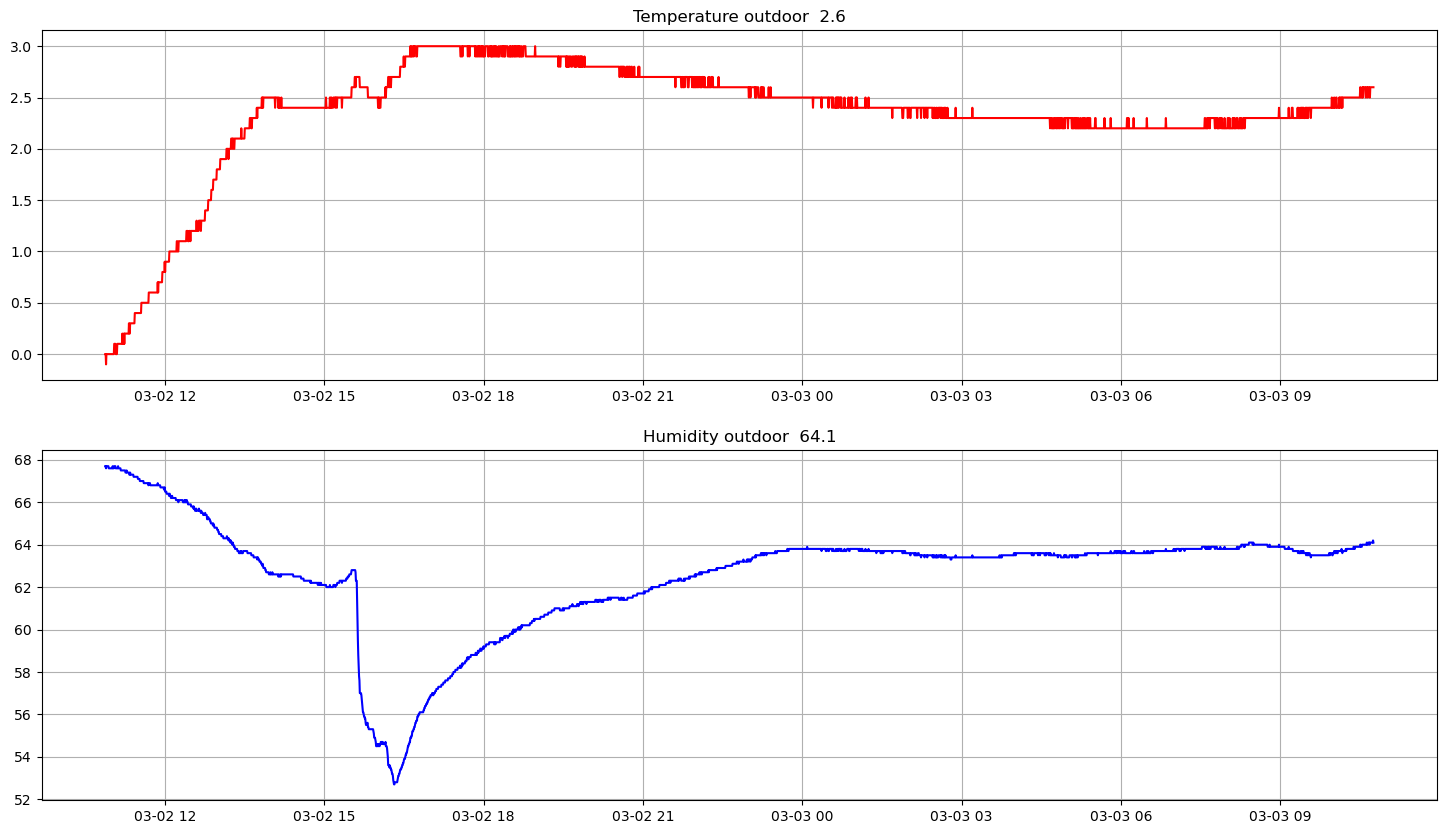

In [8]:
fig, axs = plt.subplots(2, 1,figsize=(18, 10))
axs[0].grid(True)
axs[0].set_title('Temperature outdoor  '+str(data['t_outdoor'][-1]))
axs[0].plot(data.index, data['t_outdoor'], color='red')
axs[1].grid(True)
axs[1].set_title('Humidity outdoor  '+str(data['h_outdoor'][-1]))
axs[1].plot(data.index, data['h_outdoor'], color='blue')
plt.show()

### Погреб

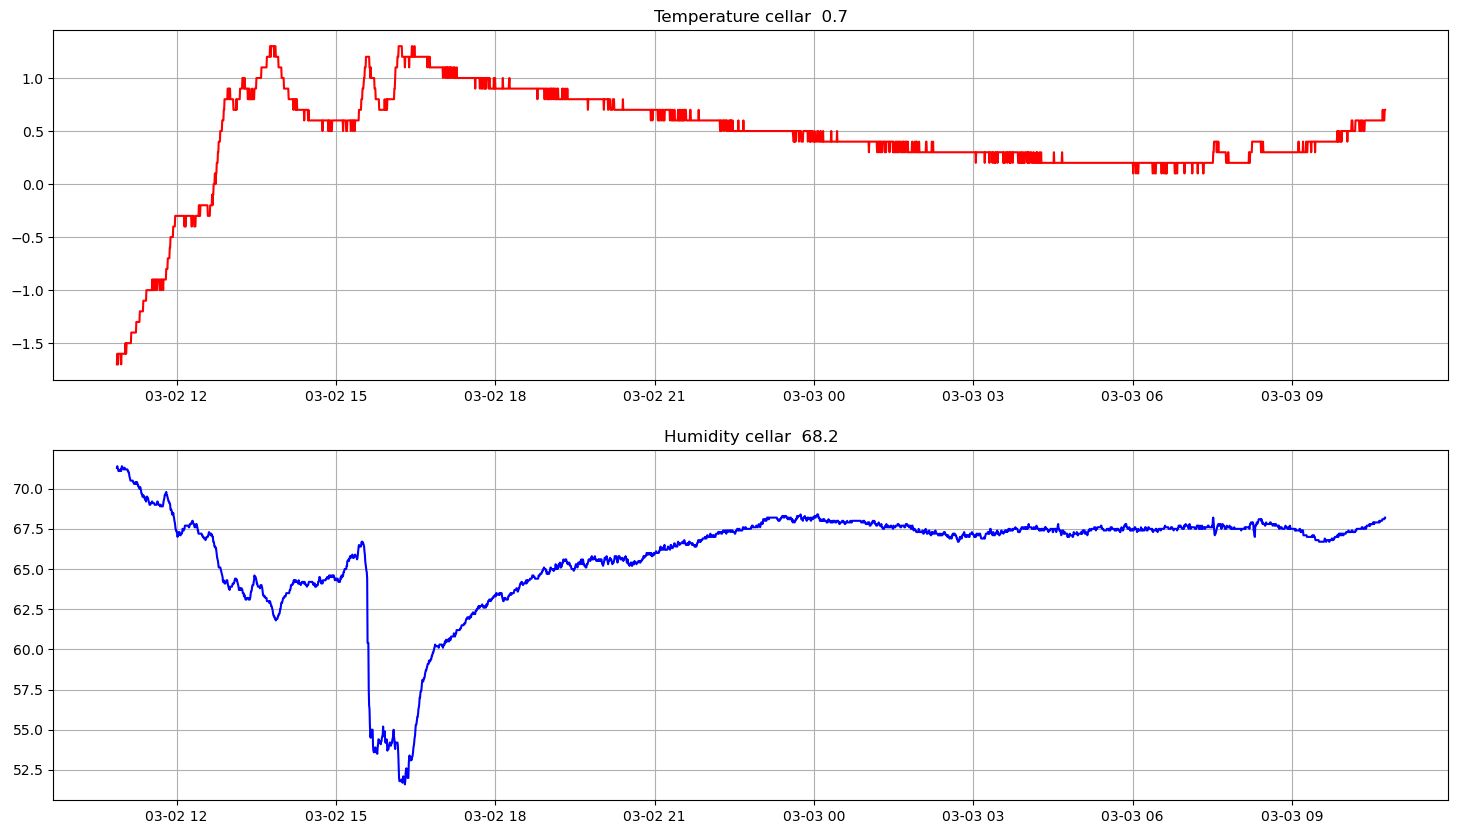

In [9]:
fig, axs = plt.subplots(2, 1,figsize=(18, 10))
axs[0].grid(True)
axs[0].set_title('Temperature cellar  '+str(data['t_cellar'][-1]))
axs[0].plot(data.index, data['t_cellar'], color='red')
axs[1].grid(True)
axs[1].set_title('Humidity cellar  '+str(data['h_cellar'][-1]))
axs[1].plot(data.index, data['h_cellar'], color='blue')
plt.show()